In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [ ]:
feature_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg"
)


In [ ]:
def extract_feature(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return feature_model.predict(img, verbose=0).flatten()


In [ ]:
def get_data(folder_path, fruit_list=None):
    X, y_s1, y_class = [], [], []
    
    # Identify if folder has fruit/veg subfolders
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    has_category_split = any(cat in subfolders for cat in ["fruit", "vegetable"])

    if has_category_split:
        for cat in ["fruit", "vegetable"]:
            cat_p = os.path.join(folder_path, cat)
            if not os.path.exists(cat_p): continue
            for cls in os.listdir(cat_p):
                cls_p = os.path.join(cat_p, cls)
                if not os.path.isdir(cls_p): continue
                for img in os.listdir(cls_p):
                    X.append(extract_feature(os.path.join(cls_p, img)))
                    y_s1.append(0 if cat == "fruit" else 1)
                    y_class.append(cls)
    else:
        for cls in os.listdir(folder_path):
            cls_p = os.path.join(folder_path, cls)
            if not os.path.isdir(cls_p): continue
            label = 0 if (fruit_list and cls in fruit_list) else 1
            for img in os.listdir(cls_p):
                X.append(extract_feature(os.path.join(cls_p, img)))
                y_s1.append(label)
                y_class.append(cls)
                
    return np.array(X), np.array(y_s1), np.array(y_class)

# --- EXECUTION STEPS ---
# 1. Manually define fruit_set from the TRAIN folder structure
train_fruit_path = os.path.join(base_dir, "train", "fruit")
fruit_set = set(os.listdir(train_fruit_path)) if os.path.exists(train_fruit_path) else set()

# 2. Load all sets using the 3-variable return
X_train, y_train_s1, y_train_class = get_data(os.path.join(base_dir, "train"))
X_val, y_val_s1, y_val_class = get_data(os.path.join(base_dir, "validation"), fruit_set)
X_test, y_test_s1, y_test_class = get_data(os.path.join(base_dir, "test"), fruit_set)

print(f"Loaded {len(X_train)} Train, {len(X_val)} Val, and {len(X_test)} Test images.")

In [ ]:
# Encode class labels for ANN Stage 2
le = LabelEncoder()
y_train_class_enc = le.fit_transform(y_train_class)
y_val_class_enc = le.transform(y_val_class)
y_test_class_enc = le.transform(y_test_class)
num_classes = len(le.classes_)


In [ ]:
def build_stage1_ann(input_dim=1280):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_stage2_ann(input_dim=1280, num_classes=num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

s1_models, f_models, v_models = [], [], []

for fold, (t_idx, _) in enumerate(kf.split(X_train)):
    print(f"Training Fold {fold+1}")

    # Stage 1: Fruit vs Vegetable
    m1 = build_stage1_ann()
    m1.fit(X_train[t_idx], y_train_s1[t_idx], epochs=15, batch_size=32, verbose=0)
    s1_models.append(m1)

    # Stage 2: Fruits
    f_mask = (y_train_s1==0) & np.isin(np.arange(len(y_train_s1)), t_idx)
    mf = build_stage2_ann()
    mf.fit(X_train[f_mask], to_categorical(y_train_class_enc[f_mask], num_classes), epochs=20, batch_size=32, verbose=0)
    f_models.append(mf)

    # Stage 2: Vegetables
    v_mask = (y_train_s1==1) & np.isin(np.arange(len(y_train_s1)), t_idx)
    mv = build_stage2_ann()
    mv.fit(X_train[v_mask], to_categorical(y_train_class_enc[v_mask], num_classes), epochs=20, batch_size=32, verbose=0)
    v_models.append(mv)

print("K-Fold Training Complete!")


In [ ]:
def final_evaluate(X, y_s1_true, y_class_true):
    preds_s1, preds_s2 = [], []

    for feat in X:
        feat = feat.reshape(1, -1)

        # Stage 1 vote
        v1 = [m.predict(feat)[0][0] > 0.5 for m in s1_models]
        final_s1 = int(sum(v1) > len(v1)/2)
        preds_s1.append(final_s1)

        # Stage 2 vote
        pool = f_models if final_s1==0 else v_models
        v2 = [np.argmax(m.predict(feat)) for m in pool]
        preds_s2.append(Counter(v2).most_common(1)[0][0])

    preds_s2 = le.inverse_transform(preds_s2)

    print("--- Stage 1 Performance ---")
    print(classification_report(y_s1_true, preds_s1, target_names=["Fruit","Veg"]))

    print("\n--- Stage 2 Performance ---")
    print(classification_report(y_class_true, preds_s2))


In [ ]:
print("=== External Validation Performance ===")
final_evaluate(X_val, y_val_s1, y_val_class)


In [ ]:
print("=== Final Test Set Performance ===")
final_evaluate(X_test, y_test_s1, y_test_class)


Generating ensemble predictions for the Test Set...

Overall System Accuracy: 94.99%


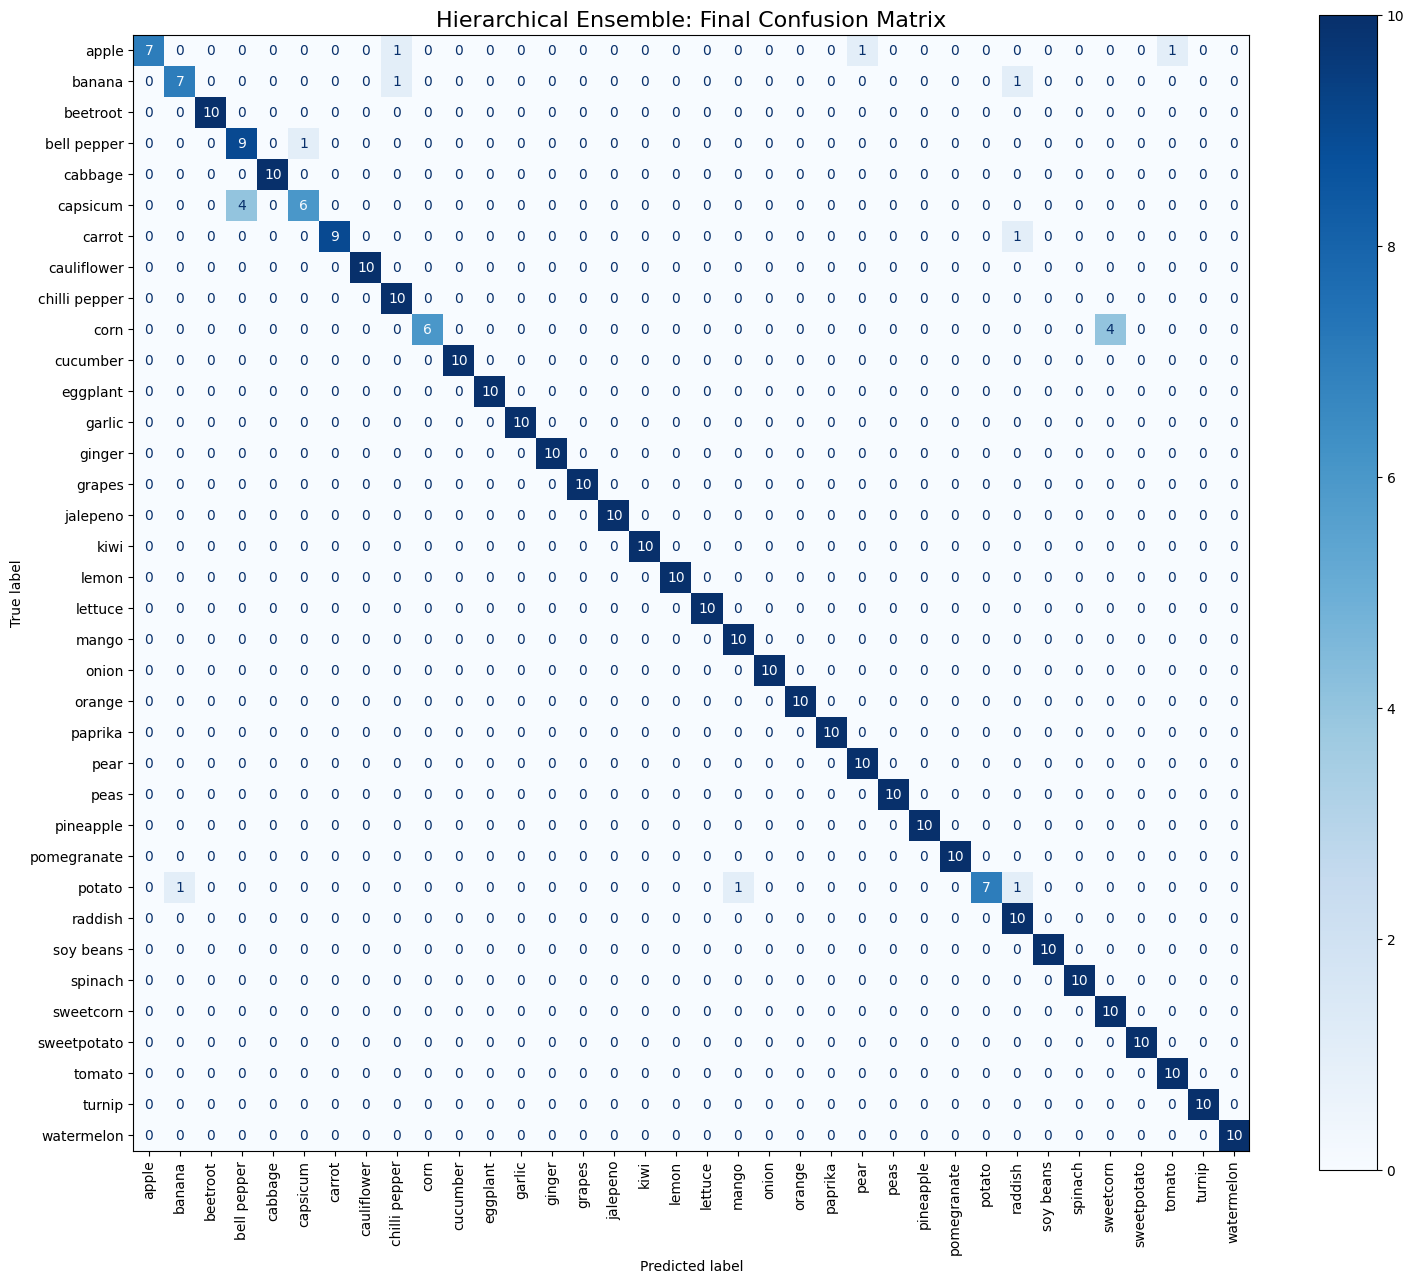

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from collections import Counter

def get_hierarchical_predictions(X, s1_models, f_models, v_models, le):
    final_preds = []
    print("Generating ensemble predictions for the Test Set...")
    
    for feat in X:
        feat = feat.reshape(1, -1)
        
        # 1. Stage 1 Vote (Sigmoid)
        s1_votes = [1 if m.predict(feat, verbose=0)[0][0] > 0.5 else 0 for m in s1_models]
        win_s1 = Counter(s1_votes).most_common(1)[0][0]
        
        # 2. Stage 2 Vote (Softmax)
        pool = f_models if win_s1 == 0 else v_models
        s2_votes = [np.argmax(m.predict(feat, verbose=0)[0]) for m in pool]
        win_s2_idx = Counter(s2_votes).most_common(1)[0][0]
        
        # 3. Convert index back to label name (e.g., 5 -> 'apple')
        final_preds.append(le.inverse_transform([win_s2_idx])[0])
        
    return final_preds

def plot_advanced_metrics(y_true, y_pred):
    # 1. Compute Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\nOverall System Accuracy: {acc * 100:.2f}%")

    # 2. Generate Confusion Matrix
    labels = sorted(list(set(y_true))) # Ensure labels match the matrix order
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # 3. Plotting
    fig, ax = plt.subplots(figsize=(18, 15))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    
    plt.title("Hierarchical Ensemble: Final Confusion Matrix", fontsize=16)
    plt.grid(False) # Clean up the visual
    plt.show()

# --- EXECUTION ---
test_preds = get_hierarchical_predictions(X_test, s1_models, f_models, v_models, le)
plot_advanced_metrics(y_test_class, test_preds)

In [ ]:
def predict_new_image_single(img_path, s1_models, f_models, v_models, le):
    # 1. Feature Extraction
    feature = extract_feature(img_path).reshape(1, -1)
    
    # 2. Stage 1: Fruit vs Veg (Binary Ensemble Vote)
    s1_votes = []
    for m in s1_models:
        # Sigmoid output: > 0.5 is Vegetable (1), < 0.5 is Fruit (0)
        prob = m.predict(feature, verbose=0)[0][0]
        s1_votes.append(1 if prob > 0.5 else 0)
    
    final_s1 = max(set(s1_votes), key=s1_votes.count)
    s1_conf = (s1_votes.count(final_s1) / len(s1_votes)) * 100
    category_name = "Fruit" if final_s1 == 0 else "Vegetable"
    
    # 3. Stage 2: Specific Class (Multi-class Ensemble Vote)
    target_models = f_models if final_s1 == 0 else v_models
    
    s2_votes = []
    for m in target_models:
        preds = m.predict(feature, verbose=0)[0]
        idx = np.argmax(preds)
        # Map index back to the original name using the global LabelEncoder
        s2_class = le.inverse_transform([idx])[0]
        s2_votes.append(s2_class)
    
    final_s2 = max(set(s2_votes), key=s2_votes.count)
    s2_conf = (s2_votes.count(final_s2) / len(s2_votes)) * 100
    
    # 4. Display Result
    plt.figure(figsize=(5, 5))
    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {final_s2}\nCategory: {category_name} ({s1_conf:.0f}% cert.)\nType Confidence: {s2_conf:.0f}%")
    plt.show()
    
    return final_s2, s2_conf

In [ ]:
# List of your local image paths
test_images = [
    r"C:\Users\nohas\Downloads\Banana-Single.jpg",
    r"C:\Users\nohas\Downloads\images (1).jpg",
    r"C:\Users\nohas\Downloads\images (2).jpg",
    r"C:\Users\nohas\Downloads\pngtree-ripe-mango-fruit-with-leaf-for-healthy-snack-png-image_15699037.png",
    r"C:\Users\nohas\Downloads\images (3).jpg"
]

print("--- Starting Predictions ---")
for path in test_images:
    if os.path.exists(path):
        try:
            name, confidence = predict_new_image_single(path, s1_models, f_models, v_models, le)
            print(f"Result for {os.path.basename(path)}: {name} ({confidence:.0f}%)")
        except Exception as e:
            print(f"Error processing {path}: {e}")
    else:
        print(f"File not found: {path}")